# Libraries

In [53]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

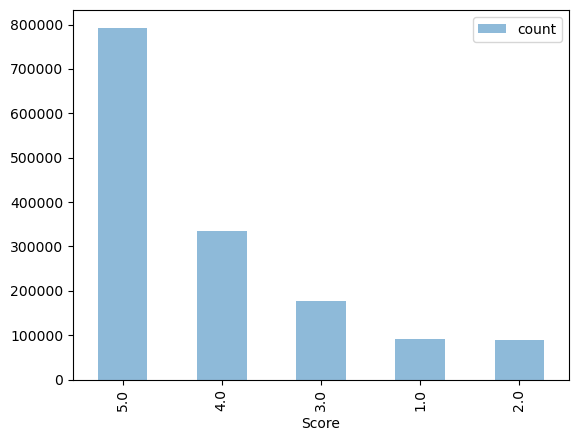


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [54]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [55]:
# from textblob import TextBlob
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Review length
    df['review_length'] = df['Text'].apply(lambda x: len(str(x).split()))

    print(df.columns)
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [56]:
# Resampling to handle class imbalance
X_train_majority = X_train[X_train['Score'] == 5]
X_train_minority = X_train[X_train['Score'] != 5]

# Downsample majority class
X_train_majority_downsampled = resample(X_train_majority,
                                        replace=False,
                                        n_samples=len(X_train_minority),
                                        random_state=0)
X_train_balanced = pd.concat([X_train_minority, X_train_majority_downsampled])

# Split training set into training and testing set
X_train_balanced, X_test, Y_train, Y_test = train_test_split(
    X_train_balanced.drop(columns=['Score']),
    X_train_balanced['Score'],
    test_size=0.25,
    random_state=0
)

# Feature Selection

In [57]:
# Select features and scale them
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'review_length']
X = X_train_balanced['Text'].fillna('')  # Use only text for TF-IDF vectorizer and handle NaN
y = Y_train

# Custom transformer for adding VADER sentiment scores
class VaderSentimentTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vader = SentimentIntensityAnalyzer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['vader_compound'] = X_copy['Text'].apply(lambda x: self.vader.polarity_scores(str(x))['compound'])
        X_copy['vader_pos'] = X_copy['Text'].apply(lambda x: self.vader.polarity_scores(str(x))['pos'])
        X_copy['vader_neu'] = X_copy['Text'].apply(lambda x: self.vader.polarity_scores(str(x))['neu'])
        X_copy['vader_neg'] = X_copy['Text'].apply(lambda x: self.vader.polarity_scores(str(x))['neg'])
        return X_copy[['vader_compound', 'vader_pos', 'vader_neu', 'vader_neg']]

# Set up TF-IDF for text processing
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 2))

# Model Creation

In [59]:
# Use FeatureUnion to combine feature sets
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text_features', tfidf),
        ('vader_features', VaderSentimentTransformer()),
        ('scaler', StandardScaler())
    ])),
    ('svd', TruncatedSVD(n_components=5)),
    ('knn', KNeighborsClassifier())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'knn__n_neighbors': [5, 10, 15],          # Test a few k values
    'knn__weights': ['uniform', 'distance'],  # Test both uniform and distance weighting
    'knn__p': [1, 2]                          # Manhattan and Euclidean distance
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=4, verbose=2)

# Fit GridSearchCV
grid_search.fit(X, y)

# Display the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# Display all grid search results with respective scores
print("\nGrid search results:")
for mean_score, std_dev, params in zip(grid_search.cv_results_['mean_test_score'],
                                       grid_search.cv_results_['std_test_score'],
                                       grid_search.cv_results_['params']):
    print(f"Score: {mean_score:.4f} (+/-{std_dev:.4f}) for parameters: {params}")

# Use the best estimator for final predictions
best_model = grid_search.best_estimator_

# Predict the score using the model
y_test_predictions = best_model.predict(X_test['Text'].fillna(''))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


# Model Evaluation

Accuracy on testing set =  0.5251770498340023


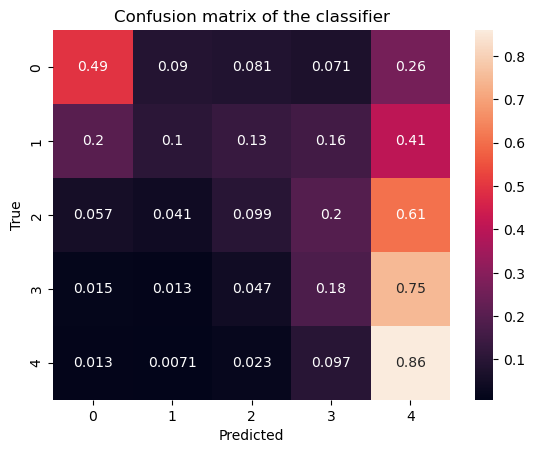

In [ ]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [ ]:
# Create the submission file
X_submission['Score'] = best_model.predict(X_submission['Text'].fillna(''))
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)